Epoch 1/5
140/140 [==============================] - 3s 16ms/step - loss: 0.2180 - accuracy: 0.9188 - val_loss: 0.0559 - val_accuracy: 0.9865
Epoch 2/5
140/140 [==============================] - 2s 15ms/step - loss: 0.0363 - accuracy: 0.9890 - val_loss: 0.0412 - val_accuracy: 0.9910
Epoch 3/5
140/140 [==============================] - 2s 15ms/step - loss: 0.0113 - accuracy: 0.9969 - val_loss: 0.0426 - val_accuracy: 0.9910
Epoch 4/5
140/140 [==============================] - 2s 15ms/step - loss: 0.0059 - accuracy: 0.9989 - val_loss: 0.0446 - val_accuracy: 0.9919
Epoch 5/5
35/35 [==============================] - 0s 2ms/step


C:\Users\NyZK0\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Accuracy: 0.9910313901345291
Precision: 0.9910468021368611
Recall: 0.9910313901345291
F1 Score: 0.9909261771499716
              precision    recall  f1-score   support

         ham       0.99      1.00      0.99       966
        spam       0.99      0.94      0.97       149

    accuracy                           0.99      1115
   macro avg       0.99      0.97      0.98      1115
weighted avg       0.99      0.99      0.99      1115



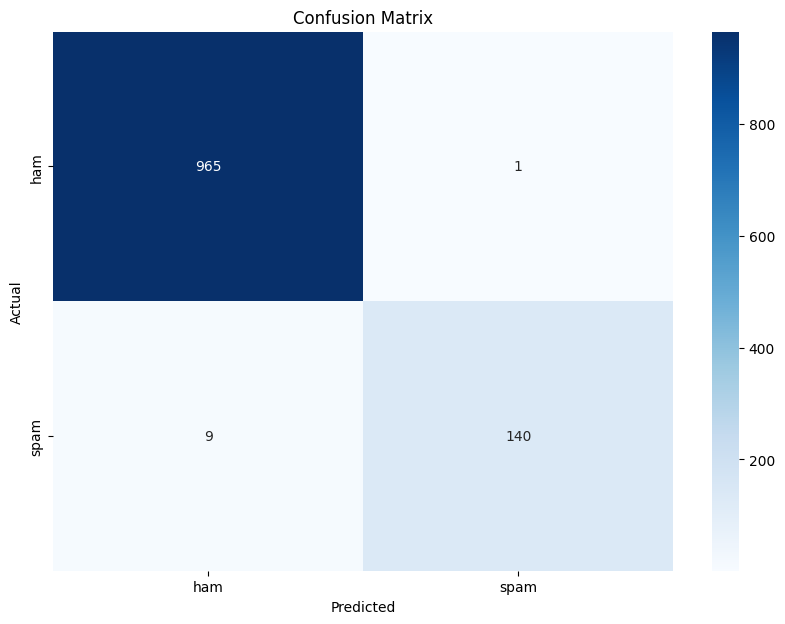

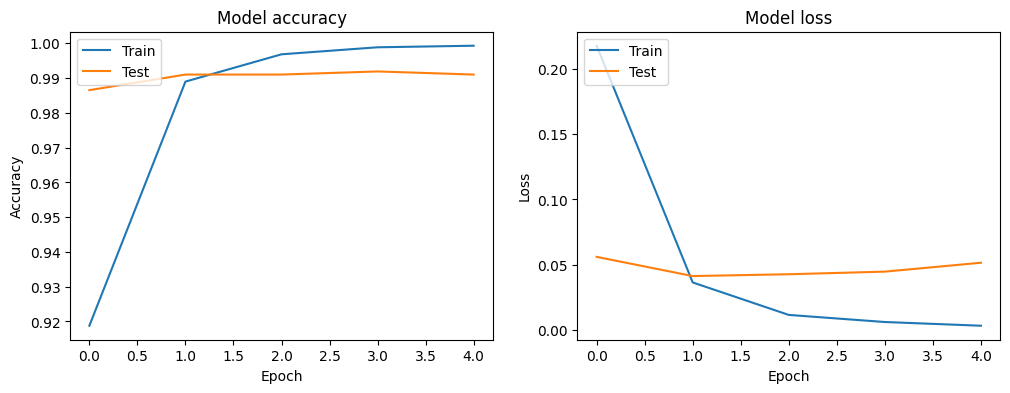

In [2]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import joblib
import json
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import seaborn as sns

# Load and prepare the dataset
df = pd.read_csv('enron_05_17_2015_with_labels_v2.csv_enron_05_17_2015_with_labels_v2.csv')
df['Text'] = df['Message'].fillna('')
df['Text'] = df['Text'].apply(lambda text: re.sub(r'\W', ' ', text.lower()).strip())
label_encoder = LabelEncoder()
df['Label'] = label_encoder.fit_transform(df['Category'])

# Tokenization and Padding
MAX_WORDS = 10000
MAX_LEN = 100
tokenizer = Tokenizer(num_words=MAX_WORDS)
tokenizer.fit_on_texts(df['Text'])
sequences = tokenizer.texts_to_sequences(df['Text'])
X = pad_sequences(sequences, maxlen=MAX_LEN)
y = df['Label']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Building the CNN model
model_cnn = Sequential()
model_cnn.add(Embedding(MAX_WORDS, 128, input_length=MAX_LEN))
model_cnn.add(Conv1D(64, 5, activation='relu'))
model_cnn.add(MaxPooling1D(pool_size=4))
model_cnn.add(Flatten())
model_cnn.add(Dropout(0.5))
model_cnn.add(Dense(2, activation='softmax'))
model_cnn.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the CNN model
history_cnn = model_cnn.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test))

# Save the model
model_cnn.save('cnn_model.h5')

# Save the tokenizer
with open('tokenizer.json', 'w') as f:
    f.write(tokenizer.to_json())

# Save the label encoder
joblib.dump(label_encoder, 'label_encoder.pkl')

# Evaluate the model
y_pred = model_cnn.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Calculate performance metrics
accuracy = accuracy_score(y_test, y_pred_classes)
precision = precision_score(y_test, y_pred_classes, average='weighted')
recall = recall_score(y_test, y_pred_classes, average='weighted')
f1 = f1_score(y_test, y_pred_classes, average='weighted')

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

# Generate classification report
report = classification_report(y_test, y_pred_classes, target_names=label_encoder.classes_)
print(report)

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_cnn.history['accuracy'])
plt.plot(history_cnn.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history_cnn.history['loss'])
plt.plot(history_cnn.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()
